In [110]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [111]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time



In [112]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes

problem_formulation = 4 # 0, 1, 2, 3, 4, 5
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

In [113]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [114]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [115]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Expected Annual Damage', variable_name=('A.1_Expected Annual Damage',), function=<function sum_over at 0x13e3c9300>)
ScalarOutcome('A.1 Dike Investment Costs', variable_name=('A.1_Dike Investment Costs',), function=<function sum_over at 0x13e3c9300>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x13e3c9300>)
ScalarOutcome('A.2 Expected Annual Damage', variable_name=('A.2_Expected Annual Damage',), function=<function sum_over at 0x13e3c9300>)
ScalarOutcome('A.2 Dike Investment Costs', variable_name=('A.2_Dike Investment Costs',), function=<function sum_over at 0x13e3c9300>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<function sum_over at 0x13e3c9300>)
ScalarOutcome('A.3 Expected Annual Damage', variable_name=('A.3_Expected Annual Damage',), function=<function sum_over at 0x13e3c9300>)
ScalarOutcome('A.3 Dike Investment Costs

## Defining own policies

In [117]:
# defining specific policies
# for example, policy 1 is about extra protection in upper boundary
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations


def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [

    Policy("Do Nothing", **get_do_nothing_dict()),

    # Policy("RFR 0", **dict(
    #     get_do_nothing_dict(),
    #     **{"0_RfR 0": 1}
    # )),

    # Policy("RFR 1", **dict(
    #     get_do_nothing_dict(),
    #     **{"1_RfR 0": 1}
    # )),

    # Policy("RFR 2", **dict(
    #     get_do_nothing_dict(),
    #     **{"2_RfR 0": 1}
    # )),

    # Policy("RFR 3", **dict(
    #     get_do_nothing_dict(),
    #     **{"3_RfR 0": 1}
    # )),

    # Policy("RFR 4", **dict(
    #     get_do_nothing_dict(),
    #     **{"4_RfR 0": 1}
    # )),

    Policy("Early Warning", **dict(
        get_do_nothing_dict(),
        **{"EWS_DaysToThreat": 4}
    )),

    Policy("Max Dike Increase A.1", **dict(
        get_do_nothing_dict(),
        **{"A.1_DikeIncrease 0": 10}
    )),

    Policy("Max Dike Increase A.2", **dict(
        get_do_nothing_dict(),
        **{"A.2_DikeIncrease 0": 10}
    )),

    Policy("Max Dike Increase A.3", **dict(
        get_do_nothing_dict(),
        **{"A.3_DikeIncrease 0": 10}
    )),

    Policy("Max Dike Increase A.4", **dict(
        get_do_nothing_dict(),
        **{"A.4_DikeIncrease 0": 10}
    )),

    Policy("Max Dike Increase A.5", **dict(
        get_do_nothing_dict(),
        **{"A.5_DikeIncrease 0": 10}
    )),

]

In [118]:
# pass the policies list to EMA workbench experiment runs
n_scenarios = 100
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/ninakerff/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEv

In [119]:
experiments, outcomes = results


In [120]:
outcomes = outcomes.copy()
outcomes['policy'] = experiments['policy'].values
df_outcomes = pd.DataFrame(outcomes)
df_outcomes.head()


,A.1 Expected Annual Damage,A.1 Dike Investment Costs,A.1_Expected Number of Deaths,A.2 Expected Annual Damage,A.2 Dike Investment Costs,A.2_Expected Number of Deaths,A.3 Expected Annual Damage,A.3 Dike Investment Costs,A.3_Expected Number of Deaths,A.4 Expected Annual Damage,A.4 Dike Investment Costs,A.4_Expected Number of Deaths,A.5 Expected Annual Damage,A.5 Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,policy
0,6.204497e+07,0,0.048945,1.647632e+08,0,0.166093,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,3.463108e+08,0,0.334065,0.0,0.0,Do Nothing
1,2.199401e+09,0,1.440704,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,1.811907e+06,0,0.000738,0.000000e+00,0,0.000000,0.0,0.0,Do Nothing
2,9.264285e+07,0,0.065017,2.731091e+07,0,0.025735,9.829287e+06,0,0.017691,0.000000e+00,0,0.000000,1.820260e+07,0,0.016474,0.0,0.0,Do Nothing
3,7.900802e+06,0,0.004981,5.882871e+07,0,0.048711,4.257854e+07,0,0.066465,7.910184e+07,0,0.031221,6.992743e+08,0,0.520390,0.0,0.0,Do Nothing
4,7.454384e+08,0,0.480924,0.000000e+00,0,0.000000,1.260638e+09,0,2.029884,1.208673e+08,0,0.045152,0.000000e+00,0,0.000000,0.0,0.0,Do Nothing


# Plot of costs for dike heightening policies

/Users/ninakerff/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


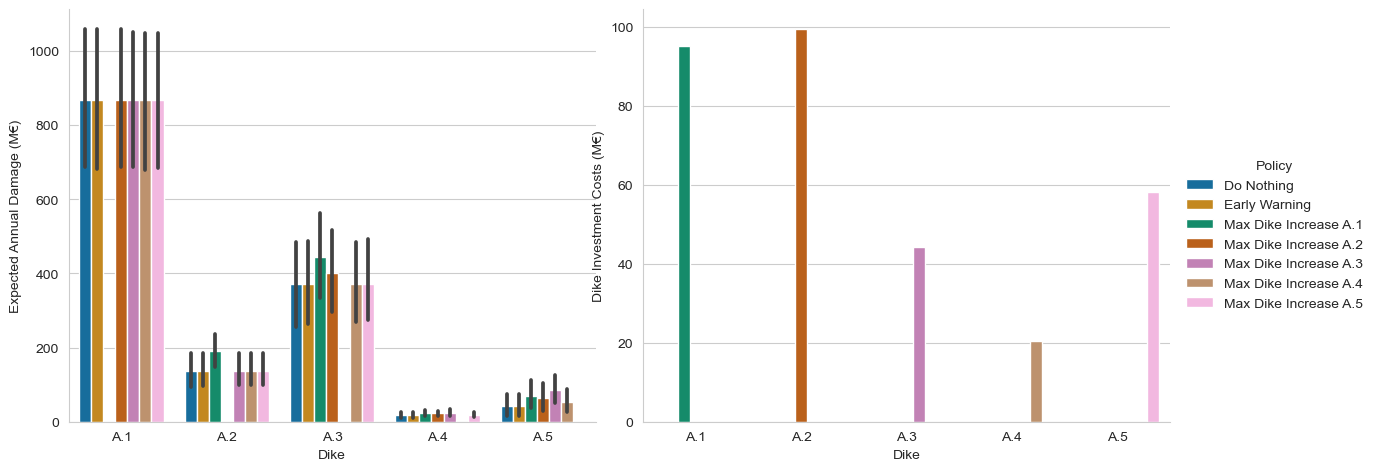

In [121]:
# Prepare list of dikes and metrics
dikes = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths']

# Build a long-format DataFrame
rows = []
for _, row in df_outcomes.iterrows():
    policy = row['policy']
    for dike in dikes:
        rows.append({
            'policy': policy,
            'Segment': dike,
            'Metric': 'Expected Annual Damage',
            'Value': row[f'{dike} Expected Annual Damage']/1e6
        })
        rows.append({
            'policy': policy,
            'Segment': dike,
            'Metric': 'Dike Investment Costs',
            'Value': row[f'{dike} Dike Investment Costs']/1e6
        })
        rows.append({
            'policy': policy,
            'Segment': dike,
            'Metric': 'Expected Number of Deaths',
            'Value': row[f'{dike}_Expected Number of Deaths']
        })

df_long = pd.DataFrame(rows)


# Filter for the two relevant metrics
filtered_df = df_long[df_long['Metric'].isin([
    'Expected Annual Damage',
    'Dike Investment Costs'
])]


sns.set_palette("colorblind")

# Create the plot
g = sns.catplot(
    data=filtered_df,
    x='Segment',
    y='Value',
    hue='policy',
    col='Metric',
    kind='bar',
    palette="colorblind",
    height=5,
    aspect=1.2,
    sharey=False
)

# Remove default column titles
g.set_titles("")

# Set custom y-axis labels per subplot
metric_labels = ['Expected Annual Damage (M€)', 'Dike Investment Costs (M€)']
for i, label in enumerate(metric_labels):
    g.axes[0, i].set_ylabel(label)

# Set common x-axis label
g.set_xlabels("Dike")

# Adjust legend
g._legend.set_title("Policy")

plt.show()

# Plot of costs for RfR projects

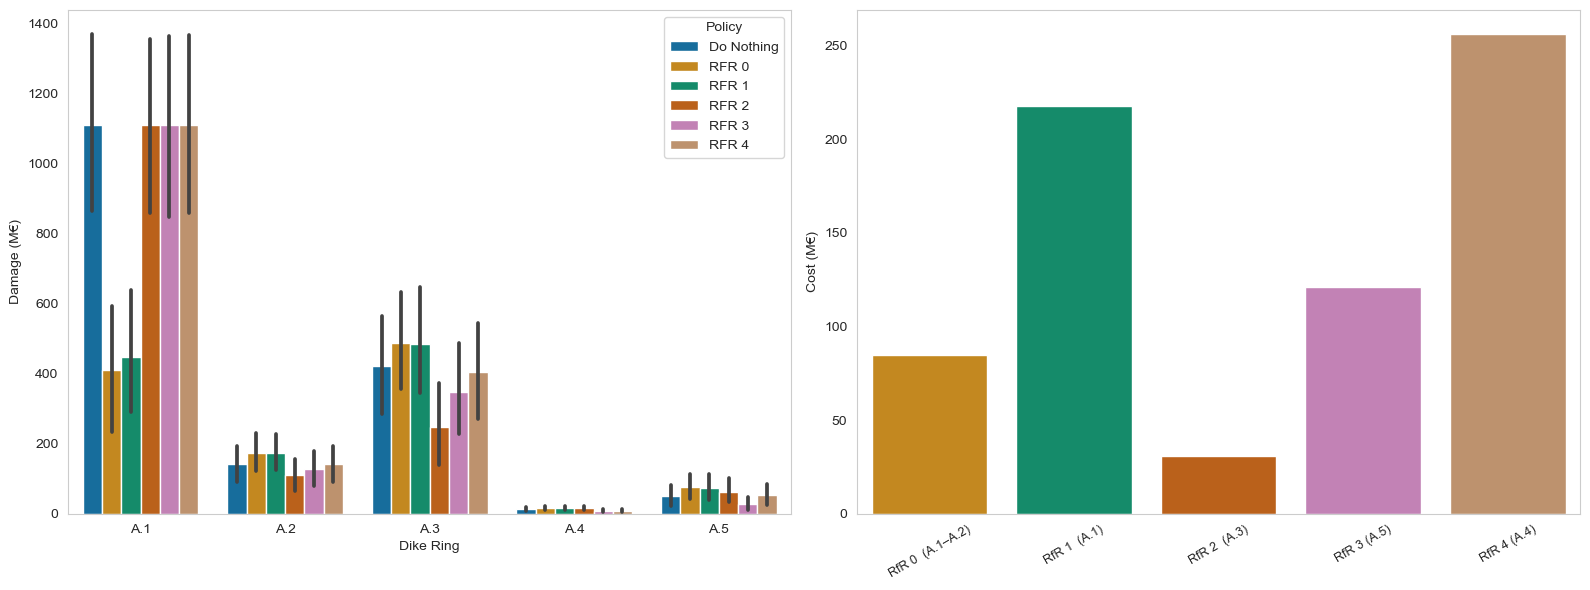

In [109]:


# Dike rings
dikes = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']

# Build left plot data (Expected Annual Damage per policy per dike ring)
rows = []
for _, row in df_outcomes.iterrows():
    policy = row['policy']
    for dike in dikes:
        rows.append({
            'policy': policy,
            'Segment': dike,
            'Metric': 'Expected Annual Damage',
            'Value': row[f'{dike} Expected Annual Damage'] / 1e6  # in millions €
        })

df_damage = pd.DataFrame(rows)

# ----------------------------
# RfR Cost data for right plot
# ----------------------------

rfr_names = [
    "RfR 0  (A.1–A.2)",
    "RfR 1  (A.1)",
    "RfR 2  (A.3)",
    "RfR 3 (A.5)",
    "RfR 4 (A.4)"
]

rfr_costs_raw = ["84,6", "217,8", "30,7", "121,2", "256,1"]
rfr_costs = [float(c.replace(',', '.')) for c in rfr_costs_raw]

df_rfr = pd.DataFrame({
    'Name': rfr_names,
    'Cost (M€)': rfr_costs
})

# ----------------------------
# Plotting both subplots consistently
# ----------------------------

sns.set_style("whitegrid")
palette = sns.color_palette("colorblind")
custom_rfr_colors = palette[1:6]  # use colors 2 to 6 (index 1–5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot – Expected Annual Damage per Dike Ring
sns.barplot(
    data=df_damage,
    x='Segment',
    y='Value',
    hue='policy',
    ax=ax1,
    palette=palette,
    edgecolor=None  # remove white gaps between bars
)
#ax1.set_title('Expected Annual Damage per Dike Ring', fontsize=12)
ax1.set_ylabel('Damage (M€)')
ax1.set_xlabel('Dike Ring')
ax1.tick_params(axis='x', rotation=0)
ax1.legend(title='Policy')
ax1.grid(False)

# Right plot – RfR Investment Costs with specific colors and no white lines
sns.barplot(
    data=df_rfr,
    x='Name',
    y='Cost (M€)',
    ax=ax2,
    palette=custom_rfr_colors,
    edgecolor=None  # remove white edges between bars
)
#ax2.set_title('RfR Project Costs', fontsize=12)
ax2.set_ylabel('Cost (M€)')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=30, labelsize=9)
ax2.grid(False)

plt.tight_layout()
plt.show()